In [1]:
# Load all the packages required for the analysis
library(tidyverse)
library(ggplot2) # Visualisation
install.packages("corrgram")
install.packages("caret")
library(caret)
library(corrgram)
install.packages("Metrics")
library(Metrics)

library(rpart)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
also installing the dependencies ‘gridExtra’, ‘viridis’, ‘gtools’, ‘gdata’, ‘caTools’, ‘TSP’, ‘qap’, ‘cluster’, ‘gclus’, ‘dendextend’, ‘gplots’, ‘registry’, ‘seriation’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Registered S3 method overwritten by 'seriation':
  method         from 
  reorder.hclust gclus

Attaching package: ‘corrgram’

The following object is masked from ‘

In [57]:
############################################Explore the data##########################################
## Read the data
train_df <- read.csv("./train_cab.csv", stringsAsFactors=FALSE)
dim(train_df)
test_df <- read.csv("./test.csv", stringsAsFactors=FALSE)
# column names
names(train_df)
# datatypes
str(train_df)

[1] 16067     7

[1] "fare_amount"       "pickup_datetime"   "pickup_longitude" 
[4] "pickup_latitude"   "dropoff_longitude" "dropoff_latitude" 
[7] "passenger_count"

'data.frame':	16067 obs. of  7 variables:
 $ fare_amount      : chr  "4.5" "16.9" "5.7" "7.7" ...
 $ pickup_datetime  : chr  "2009-06-15 17:26:21 UTC" "2010-01-05 16:52:16 UTC" "2011-08-18 00:35:00 UTC" "2012-04-21 04:30:42 UTC" ...
 $ pickup_longitude : num  -73.8 -74 -74 -74 -74 ...
 $ pickup_latitude  : num  40.7 40.7 40.8 40.7 40.8 ...
 $ dropoff_longitude: num  -73.8 -74 -74 -74 -74 ...
 $ dropoff_latitude : num  40.7 40.8 40.8 40.8 40.8 ...
 $ passenger_count  : num  1 1 2 1 1 1 1 1 1 2 ...


#### From above data we can see fare amount having char datatype also from datetime we can extract year,date and time for model development 
### Data preprocessing

In [58]:
train_df$fare_amount = as.numeric(as.character(train_df$fare_amount))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [59]:
# removed -ve ,zero and above 100 values
train_df = train_df[-which(train_df$fare_amount < 1 ),]

train_df = train_df[-which(train_df$fare_amount > 100 ),]


In [60]:
train_df = train_df[-which(train_df$passenger_count > 6 ),]

#### here I have removed fare amount which are having -ve ,zeroand above 100 values

In [61]:
dim(train_df)


[1] 16033     7

In [62]:
#Convert pickup_datetime from factor to date time
train_df$pickup_date = as.Date(as.character(train_df$pickup_datetime))
train_df$pickup_mnth = as.factor(format(train_df$pickup_date,"%m"))
train_df$pickup_yr = as.factor(format(train_df$pickup_date,"%Y"))
pickup_time = strptime(train_df$pickup_datetime,"%Y-%m-%d %H:%M:%S")
train_df$pickup_hour = as.factor(format(pickup_time,"%H"))
#Convert pickup_datetime from factor to date time
test_df$pickup_date = as.Date(as.character(test_df$pickup_datetime))
test_df$pickup_mnth = as.factor(format(test_df$pickup_date,"%m"))
test_df$pickup_yr = as.factor(format(test_df$pickup_date,"%Y"))
pickup_time = strptime(test_df$pickup_datetime,"%Y-%m-%d %H:%M:%S")
test_df$pickup_hour = as.factor(format(pickup_time,"%H"))

#### here I have extracted year, month, date ,time features from pickup_datetime also I have done the data type conversion

In [63]:
dim(test_df)

[1] 9914   10

In [64]:
# Calculate the distance travelled using longitude and latitude
deg_to_rad = function(deg){
  (deg * pi) / 180
}
distance = function(long1,lat1,long2,lat2){
  #long1rad = deg_to_rad(long1)
  phi1 = deg_to_rad(lat1)
  #long2rad = deg_to_rad(long2)
  phi2 = deg_to_rad(lat2)
  delphi = deg_to_rad(lat2 - lat1)
  dellamda = deg_to_rad(long2 - long1)
  
  a = sin(delphi/2) * sin(delphi/2) + cos(phi1) * cos(phi2) * 
    sin(dellamda/2) * sin(dellamda/2)
  
  c = 2 * atan2(sqrt(a),sqrt(1-a))
  R = 6371e3
  R * c / 1000 #1000 is used to convert to meters
}

#### The above function is a haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

In [65]:
# Using haversine formula to calculate distance fr both train and test
train_df$distance = distance(train_df$pickup_longitude,train_df$pickup_latitude,train_df$dropoff_longitude,train_df$dropoff_latitude)
test_df$distance = distance(test_df$pickup_longitude,test_df$pickup_latitude,test_df$dropoff_longitude,test_df$dropoff_latitude)

In [66]:
##################################Missing Values Analysis###############################################

missing_val = data.frame(apply(train_df,2,function(x){sum(is.na(x))}))
missing_val




,apply.train_df..2..function.x...
,<int>
fare_amount,24
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,55
pickup_date,1
pickup_mnth,1


In [67]:
train_df$fare_amount[is.na(train_df$fare_amount)] = mean(train_df$fare_amount, na.rm = T)
train_df$passenger_count[is.na(train_df$passenger_count)] = median(train_df$passenger_count, na.rm = T)



In [68]:
missing_val = data.frame(apply(train_df,2,function(x){sum(is.na(x))}))
missing_val

,apply.train_df..2..function.x...
,<int>
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0
pickup_date,1
pickup_mnth,1


In [69]:

train_df=na.omit(train_df)

In [70]:
train_df$pickup_mnth = as.factor(as.character(train_df$pickup_mnth))
train_df$pickup_yr = as.factor(as.character(train_df$pickup_yr))
train_df$pickup_hour = as.numeric(train_df$pickup_hour)
test_df$pickup_mnth = as.factor(as.character(test_df$pickup_mnth))
test_df$pickup_yr = as.factor(as.character(test_df$pickup_yr))
test_df$pickup_hour = as.numeric(test_df$pickup_hour)

In [71]:
dim(train_df)

[1] 16032    12

In [72]:
summary(train_df)

  fare_amount    pickup_datetime    pickup_longitude pickup_latitude 
 Min.   : 1.14   Length:16032       Min.   :-74.44   Min.   :-74.01  
 1st Qu.: 6.00   Class :character   1st Qu.:-73.99   1st Qu.: 40.73  
 Median : 8.50   Mode  :character   Median :-73.98   Median : 40.75  
 Mean   :11.27                      Mean   :-72.47   Mean   : 39.92  
 3rd Qu.:12.50                      3rd Qu.:-73.97   3rd Qu.: 40.77  
 Max.   :96.00                      Max.   : 40.77   Max.   :401.08  
                                                                     
 dropoff_longitude dropoff_latitude passenger_count  pickup_date        
 Min.   :-74.23    Min.   :-74.01   Min.   :0.000   Min.   :2009-01-01  
 1st Qu.:-73.99    1st Qu.: 40.73   1st Qu.:1.000   1st Qu.:2010-08-08  
 Median :-73.98    Median : 40.75   Median :1.000   Median :2012-03-15  
 Mean   :-72.47    Mean   : 39.90   Mean   :1.642   Mean   :2012-03-17  
 3rd Qu.:-73.96    3rd Qu.: 40.77   3rd Qu.:2.000   3rd Qu.:2013-10-10  
 M

In [73]:
summary(test_df)

 pickup_datetime    pickup_longitude pickup_latitude dropoff_longitude
 Length:9914        Min.   :-74.25   Min.   :40.57   Min.   :-74.26   
 Class :character   1st Qu.:-73.99   1st Qu.:40.74   1st Qu.:-73.99   
 Mode  :character   Median :-73.98   Median :40.75   Median :-73.98   
                    Mean   :-73.97   Mean   :40.75   Mean   :-73.97   
                    3rd Qu.:-73.97   3rd Qu.:40.77   3rd Qu.:-73.96   
                    Max.   :-72.99   Max.   :41.71   Max.   :-72.99   
                                                                      
 dropoff_latitude passenger_count  pickup_date          pickup_mnth  
 Min.   :40.57    Min.   :1.000   Min.   :2009-01-01   06     :1495  
 1st Qu.:40.74    1st Qu.:1.000   1st Qu.:2010-11-17   09     :1073  
 Median :40.75    Median :1.000   Median :2012-01-26   10     : 943  
 Mean   :40.75    Mean   :1.671   Mean   :2012-05-05   12     : 933  
 3rd Qu.:40.77    3rd Qu.:2.000   3rd Qu.:2014-01-11   03     : 908  
 Max.   :41.

### from the summary of train data and test data we can see the average values ,min and maximum values ,outliers 
### pickup_latitude have 1 outlier in training dataset

In [74]:

colSums(train_df[c("pickup_latitude")] > 80)

pickup_latitude 
              1

In [75]:

train_df = train_df[-which(train_df$pickup_latitude > 80 ),]

In [76]:
numeric_index = sapply(train_df,is.numeric)
##################################Feature Selection################################################
## Correlation Plot 
train_correlations <- cor(train_df[,numeric_index])
train_correlations


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,distance
fare_amount,1.000000000,0.003612211,-0.005281836,0.003455878,-0.0052443169,0.0098991335,-0.031121119,0.030327568
pickup_longitude,0.003612211,1.000000000,-0.983516138,0.963448102,-0.9515643376,-0.0027840527,-0.008246860,0.133030538
pickup_latitude,-0.005281836,-0.983516138,1.000000000,-0.949212865,0.9701727519,0.0018149904,0.010106587,-0.124683055
dropoff_longitude,0.003455878,0.963448102,-0.949212865,1.000000000,-0.9778882012,-0.0024242074,-0.007726925,0.120759841
dropoff_latitude,-0.005244317,-0.951564338,0.970172752,-0.977888201,1.0000000000,0.0004361996,0.009114185,-0.097648500
passenger_count,0.009899133,-0.002784053,0.001814990,-0.002424207,0.0004361996,1.0000000000,0.017668383,-0.006673928
pickup_hour,-0.031121119,-0.008246860,0.010106587,-0.007726925,0.0091141851,0.0176683833,1.000000000,0.002778759
distance,0.030327568,0.133030538,-0.124683055,0.120759841,-0.0976484997,-0.0066739276,0.002778759,1.000000000


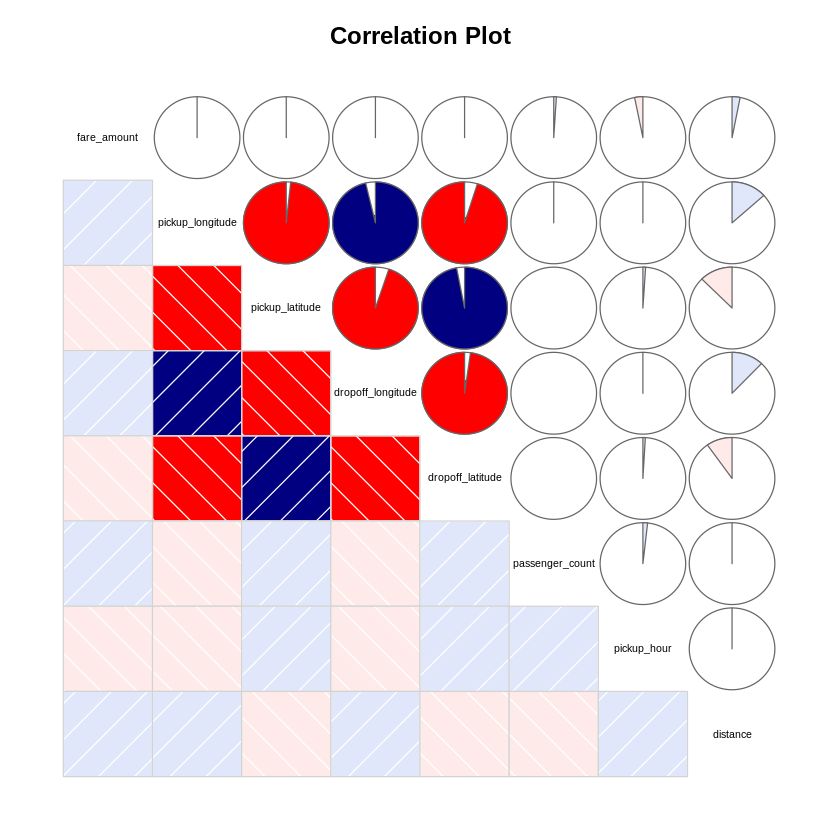

In [78]:
corrgram(train_df[,numeric_index], order = F,
         upper.panel=panel.pie, text.panel=panel.txt, main = "Correlation Plot")

from correlation analysis 

In [83]:
head(train_df)


fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_mnth,pickup_yr,pickup_hour,distance
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<fct>,<fct>,<dbl>,<dbl>
4.5,2009-06-15 17:26:21 UTC,-73.84431,40.72132,-73.84161,40.71228,1,2009-06-15,06,2009,18,1.030764
16.9,2010-01-05 16:52:16 UTC,-74.01605,40.71130,-73.97927,40.78200,1,2010-01-05,01,2010,17,8.450134
5.7,2011-08-18 00:35:00 UTC,-73.98274,40.76127,-73.99124,40.75056,2,2011-08-18,08,2011,1,1.389525
7.7,2012-04-21 04:30:42 UTC,-73.98713,40.73314,-73.99157,40.75809,1,2012-04-21,04,2012,5,2.799270
5.3,2010-03-09 07:51:00 UTC,-73.96810,40.76801,-73.95665,40.78376,1,2010-03-09,03,2010,8,1.999157
12.1,2011-01-06 09:50:45 UTC,-74.00096,40.73163,-73.97289,40.75823,1,2011-01-06,01,2011,10,3.787239


In [99]:
#Create a new subset for training model
final_train_df<-subset(train_df,select=c('fare_amount','pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude',
                                        'passenger_count','pickup_date','pickup_mnth','pickup_yr', 'pickup_hour','distance'))
#Create a new subset for training model
final_test_df<-subset(test_df,select=c('pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude',
                                        'passenger_count','pickup_date','pickup_mnth','pickup_yr', 'pickup_hour','distance'))

In [86]:
##########################################model development ##################################################

train.index = createDataPartition(final_train_df$fare_amount, p = .80, list = FALSE)
train = final_train_df[ train.index,]
test  = final_train_df[-train.index,]
str(train)

'data.frame':	12827 obs. of  11 variables:
 $ fare_amount      : num  4.5 16.9 5.7 7.7 5.3 ...
 $ pickup_longitude : num  -73.8 -74 -74 -74 -74 ...
 $ dropoff_longitude: num  -73.8 -74 -74 -74 -74 ...
 $ pickup_latitude  : num  40.7 40.7 40.8 40.7 40.8 ...
 $ dropoff_latitude : num  40.7 40.8 40.8 40.8 40.8 ...
 $ passenger_count  : num  1 1 2 1 1 1 1 1 1 3 ...
 $ pickup_date      : Date, format: "2009-06-15" "2010-01-05" ...
 $ pickup_mnth      : Factor w/ 12 levels "01","02","03",..: 6 1 8 4 3 1 1 12 4 12 ...
 $ pickup_yr        : Factor w/ 7 levels "2009","2010",..: 1 2 3 4 2 3 4 4 4 4 ...
 $ pickup_hour      : num  18 17 1 5 8 10 18 14 8 12 ...
 $ distance         : num  1.03 8.45 1.39 2.8 2 ...


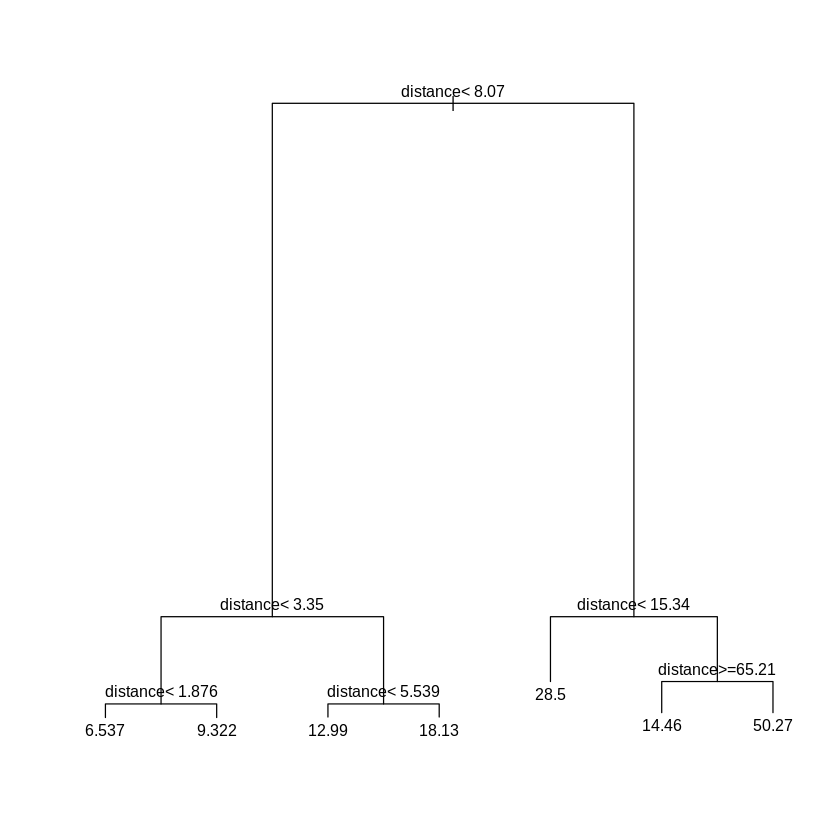

In [91]:
###################################Decision tree for regression###########################################
# 
# lets develope decision rules for predicting a continuous (regression tree) outcome.

# ##rpart for regression


fit = rpart(fare_amount ~ ., data = train, method = "anova")


# decision tree model visualisation
par(cex= 0.8)
plot(fit)
text(fit)


In [92]:
head(test_df)

pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_mnth,pickup_yr,pickup_hour,distance
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<date>,<fct>,<fct>,<dbl>,<dbl>
2015-01-27 13:08:24 UTC,-73.97332,40.76381,-73.98143,40.74384,1,2015-01-27,01,2015,14,2.3232595
2015-01-27 13:08:24 UTC,-73.98686,40.71938,-73.99889,40.73920,1,2015-01-27,01,2015,14,2.4253529
2011-10-08 11:53:44 UTC,-73.98252,40.75126,-73.97965,40.74614,1,2011-10-08,10,2011,12,0.6186279
2012-12-01 21:12:12 UTC,-73.98116,40.76781,-73.99045,40.75164,1,2012-12-01,12,2012,22,1.9610325
2012-12-01 21:12:12 UTC,-73.96605,40.78977,-73.98856,40.74443,1,2012-12-01,12,2012,22,5.3873013
2012-12-01 21:12:12 UTC,-73.96098,40.76555,-73.97918,40.74005,1,2012-12-01,12,2012,22,3.2225489


In [101]:
#Predict for new test cases

predictions_DT = predict(fit, test)


,fare_amount,pickup_longitude,dropoff_longitude,pickup_latitude,dropoff_latitude,passenger_count,pickup_date,pickup_mnth,pickup_yr,pickup_hour,distance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<fct>,<fct>,<dbl>,<dbl>
7,7.5,-73.98000,-73.97380,40.75166,40.76484,1,2012-11-20,11,2012,21,1.555807
10,8.9,-73.98066,-73.99154,40.73387,40.75814,2,2009-09-02,09,2009,2,2.849627
15,7.7,-74.00182,-73.99806,40.73755,40.72279,2,2011-04-05,04,2011,18,1.671445
16,5.0,0.00000,0.00000,0.00000,0.00000,1,2013-11-23,11,2013,13,0.000000
18,5.3,-73.98106,-73.99418,40.73769,40.72841,1,2009-07-22,07,2009,17,1.511904
22,11.5,-73.95795,-73.96125,40.77925,40.75879,1,2013-02-12,02,2013,13,2.292470


In [102]:
####################Mean Absolute Percentage Error###########################################

error <- mape(predictions_DT,test$fare_amount)
error
accuracy <- (1-error)*100
accuracy


####################Root Mean square Error###########################################
rmse(actual = test$fare_amount,predicted = predictions_DT)



[1] 0.2660005

[1] 73.39995

[1] 5.389101

In [103]:
#################################################Regression Analysis#############################################
#the base function lm is used for regression.
regmodel <- lm(fare_amount ~ ., data = train)
summary(regmodel)






Call:
lm(formula = fare_amount ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.943  -5.138  -2.739   1.308  83.462 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        8.595e+01  1.366e+02   0.629 0.529091    
pickup_longitude  -2.348e-02  1.037e-01  -0.226 0.820880    
dropoff_longitude -6.864e-03  9.630e-02  -0.071 0.943180    
pickup_latitude   -4.199e-02  1.865e-01  -0.225 0.821885    
dropoff_latitude  -1.769e-02  1.740e-01  -0.102 0.919033    
passenger_count    8.068e-02  6.517e-02   1.238 0.215733    
pickup_date       -5.336e-03  9.576e-03  -0.557 0.577360    
pickup_mnth02      5.288e-01  4.875e-01   1.085 0.278130    
pickup_mnth03      9.122e-01  6.834e-01   1.335 0.181977    
pickup_mnth04      1.695e+00  9.405e-01   1.803 0.071477 .  
pickup_mnth05      1.698e+00  1.210e+00   1.403 0.160698    
pickup_mnth06      1.386e+00  1.495e+00   0.928 0.353592    
pickup_mnth07      1.460e+00  1.785e+00   0.818

In [112]:


# lets test model
regpred <- predict(regmodel, test)

error <- mape(regpred,test$fare_amount)
error
accuracy <- (1-error)*100
accuracy
rmse(actual = test$fare_amount,predicted = regpred)


[1] 0.509387

[1] 49.0613

[1] 8.966551

In [114]:
# Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) 
# where p is number of variables in x) and regression (p/3)
##############################Random Forest model###################################

library(randomForest)

rf <- randomForest(fare_amount ~ ., data = train, ntree=20)

predictions_RF = predict(rf, test)

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin



In [115]:
####################Mean Absolute Percentage Error###########################################

error <- mape(predictions_RF,test$fare_amount)
error
accuracy <- (1-error)*100
accuracy


####################Root Mean square Error###########################################
rmse(actual = test$fare_amount,predicted = predictions_RF)



[1] 0.2057358

[1] 79.42642

[1] 4.625865

In [117]:
# Number of variables randomly sampled as candidates at each split. Note that the default values are different for classification (sqrt(p) 
# where p is number of variables and for regression we take mtry=(p/3)
##############################Random Forest model###################################

rf_2=randomForest(fare_amount ~ . , data = train,mtry =4,ntree=100 ,nodesize =10 ,importance =TRUE)

In [119]:

predictions_RF2 = predict(rf_2, test)

In [120]:
####################Mean Absolute Percentage Error###########################################

error <- mape(predictions_RF2,test$fare_amount)
error
accuracy <- (1-error)*100
accuracy


####################Root Mean square Error###########################################
rmse(actual = test$fare_amount,predicted = predictions_RF2)

[1] 0.200909

[1] 79.9091

[1] 4.600017

In [125]:
##################################### infrencing of test data #####################################3
fare_amount = predict(rf_2, test_df)

In [127]:
test_df$fare_amount = fare_amount

In [128]:
write.csv(test_df,'./final_test_data.csv')
final_test_data <- read.csv("./final_test_data.csv")
head(final_test_data)

X,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_mnth,pickup_yr,pickup_hour,distance,fare_amount
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<int>,<int>,<int>,<dbl>,<dbl>
1,2015-01-27 13:08:24 UTC,-73.97332,40.76381,-73.98143,40.74384,1,2015-01-27,1,2015,14,2.3232595,10.209672
2,2015-01-27 13:08:24 UTC,-73.98686,40.71938,-73.99889,40.73920,1,2015-01-27,1,2015,14,2.4253529,9.703376
3,2011-10-08 11:53:44 UTC,-73.98252,40.75126,-73.97965,40.74614,1,2011-10-08,10,2011,12,0.6186279,4.621415
4,2012-12-01 21:12:12 UTC,-73.98116,40.76781,-73.99045,40.75164,1,2012-12-01,12,2012,22,1.9610325,10.004530
5,2012-12-01 21:12:12 UTC,-73.96605,40.78977,-73.98856,40.74443,1,2012-12-01,12,2012,22,5.3873013,16.881922
6,2012-12-01 21:12:12 UTC,-73.96098,40.76555,-73.97918,40.74005,1,2012-12-01,12,2012,22,3.2225489,10.968475
